In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator
from keras.api._v2.keras.applications.vgg16 import VGG16
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers import Dense, LeakyReLU, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [3]:
from typing import Tuple, List

In [4]:
tf.get_logger().setLevel('WARNING')

In [5]:
def build_transfer_learning(classes: int,
                            input_shape: Tuple[int,int,int]=(224,224,3)) -> keras.Model:
  pretrained = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg')
  pretrained.trainable = False
  
  input_layer = pretrained.input
  
  net = Dense(512, activation=LeakyReLU())(pretrained.output)
  net = Dropout(0.2)(net)
  net = Dense(256, activation=LeakyReLU())(net)
  net = Dropout(0.1)(net)
  output_layer = Dense(classes, activation='softmax')(net)
  
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
  
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [6]:
def load_df(filepaths: str) -> Tuple[pd.DataFrame, List[str]]:
  labels = [str(filepaths[i]).split('\\')[-2] for i in range(len(filepaths))]
  df_labels, labels = labels, sorted(list(set(labels)))
  df_path = pd.Series(filepaths, name='Path').astype(str)
  df_labels = pd.Series(df_labels, name='Label')
  
  df = pd.concat([df_path, df_labels], axis=1)
  df = df.sample(frac=1).reset_index(drop=True)

  return df, labels

In [7]:
def train_valid_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
  labels = df.Label.unique().tolist()
  dfs_train, dfs_valid = [], []
  
  for label in labels:
    temp_df = df[df.Label == label]
    df_train, df_valid = train_test_split(temp_df, test_size=0.2)
    dfs_train.append(df_train)
    dfs_valid.append(df_valid)

  return pd.concat(dfs_train).sample(frac=1).reset_index(drop=True),\
    pd.concat(dfs_valid).sample(frac=1).reset_index(drop=True)

In [8]:
train_dir = Path('../data/train')
train_fp = list(train_dir.glob(r'**/*.*'))

test_dir = Path('../data/test/')
test_fp = list(test_dir.glob(r'**/*.*'))

In [9]:
df_train, labels = load_df(train_fp)
df_test, _ = load_df(test_fp)
df_train, df_valid = train_valid_split(df_train)

In [10]:
print(df_test.Label.unique())
print(df_train.Label.unique())
print(df_valid.Label.unique())

['mango' 'orange' 'pear' 'apple' 'lemon' 'peach' 'lime' 'dragonfruit'
 'pineapple' 'durian' 'banana']
['pineapple' 'durian' 'banana' 'pear' 'lemon' 'dragonfruit' 'peach'
 'apple' 'orange' 'lime' 'mango']
['pear' 'lime' 'apple' 'peach' 'lemon' 'pineapple' 'orange' 'mango'
 'durian' 'banana' 'dragonfruit']


In [11]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                             height_shift_range=0.2, rescale=1./255,
                             shear_range=0.1, zoom_range=0.2,
                             horizontal_flip=True, vertical_flip=True,
                             preprocessing_function=
                             keras.api._v2.keras.applications.vgg16.preprocess_input,
                             fill_mode='nearest')

datagen_test = ImageDataGenerator(preprocessing_function=
                                  keras.api._v2.keras.applications.vgg16.preprocess_input)

In [12]:
dataset_train = datagen.flow_from_dataframe(
  dataframe=df_train,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=True,
  seed=0)

dataset_valid = datagen.flow_from_dataframe(
  dataframe=df_valid,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=True,
  seed=0)

dataset_test = datagen_test.flow_from_dataframe(
  dataframe=df_test,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=False)

Found 880 validated image filenames belonging to 11 classes.
Found 220 validated image filenames belonging to 11 classes.
Found 110 validated image filenames belonging to 11 classes.


In [13]:
model = build_transfer_learning(classes=len(labels), input_shape=(224,224,3))
model.summary()

58889256/58889256 [==============================] - 48s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [14]:
tf.keras.utils.plot_model(model,
                          show_layer_names=False,
                          show_shapes=True,
                          show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
history = model.fit(dataset_train,
                    validation_data=dataset_valid,
                    batch_size=32,
                    epochs=25,
                    callbacks=[
                      EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True)])

Epoch 1/25
 5/28 [====>.........................] - ETA: 28s - loss: 2.6102 - accuracy: 0.1528

c:\Users\nicholaschen\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 [==============================] - 53s 2s/step - loss: 2.1738 - accuracy: 0.2852 - val_loss: 1.6476 - val_accuracy: 0.5136
Epoch 2/25
28/28 [==============================] - 51s 2s/step - loss: 1.3084 - accuracy: 0.6000 - val_loss: 0.9643 - val_accuracy: 0.6727
Epoch 3/25
28/28 [==============================] - 51s 2s/step - loss: 0.9294 - accuracy: 0.6818 - val_loss: 0.7571 - val_accuracy: 0.7455
Epoch 4/25
28/28 [==============================] - 51s 2s/step - loss: 0.7746 - accuracy: 0.7511 - val_loss: 0.7337 - val_accuracy: 0.7545
Epoch 5/25
28/28 [==============================] - 50s 2s/step - loss: 0.7409 - accuracy: 0.7375 - val_loss: 0.6520 - val_accuracy: 0.7682
Epoch 6/25
28/28 [==============================] - 50s 2s/step - loss: 0.5720 - accuracy: 0.8148 - val_loss: 0.5315 - val_accuracy: 0.8182
Epoch 7/25
28/28 [==============================] - 51s 2s/step - loss: 0.5718 - accuracy: 0.8080 - val_loss: 0.6653 - val_accuracy: 0.7545
Epoch 8/25
28/28 [=============

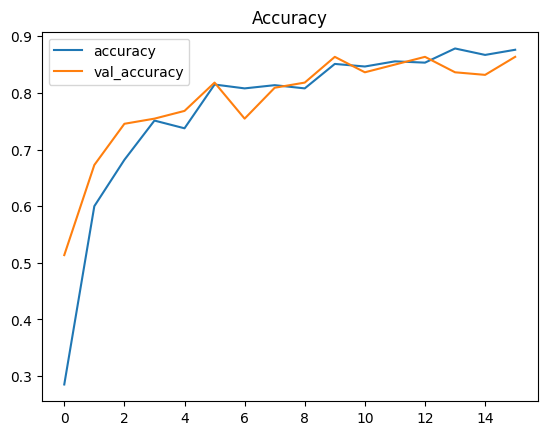

In [16]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy'); plt.show()

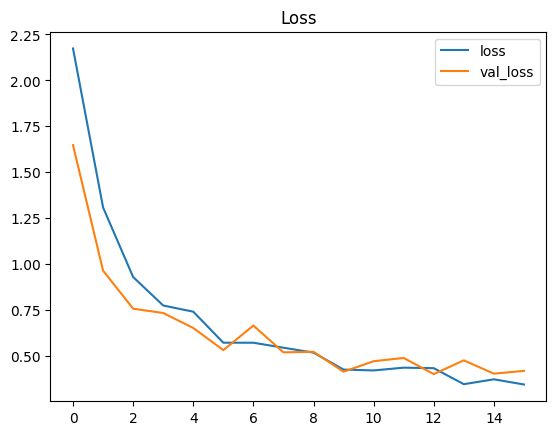

In [17]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss'); plt.show()

In [18]:
pred = model.predict(dataset_test)
pred = np.argmax(pred, axis=1)

gen_labels = (dataset_train.class_indices)
gen_labels = dict((v,k) for k,v in gen_labels.items())
pred = [gen_labels[k] for k in pred]
y_test = [gen_labels[k] for k in dataset_test.classes]

4/4 [==============================] - 5s 1s/step


In [19]:
np.unique(pred)

array(['apple', 'banana', 'dragonfruit', 'durian', 'lemon', 'lime',
       'mango', 'orange', 'pear', 'pineapple'], dtype='<U11')

In [20]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

       apple      0.529     0.900     0.667        10
      banana      0.889     0.800     0.842        10
 dragonfruit      0.643     0.900     0.750        10
      durian      1.000     1.000     1.000        10
       lemon      0.600     0.300     0.400        10
        lime      1.000     0.600     0.750        10
       mango      0.333     0.100     0.154        10
      orange      0.400     1.000     0.571        10
       peach      0.000     0.000     0.000        10
        pear      0.909     1.000     0.952        10
   pineapple      1.000     1.000     1.000        10

    accuracy                          0.691       110
   macro avg      0.664     0.691     0.644       110
weighted avg      0.664     0.691     0.644       110



c:\Users\nicholaschen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicholaschen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicholaschen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

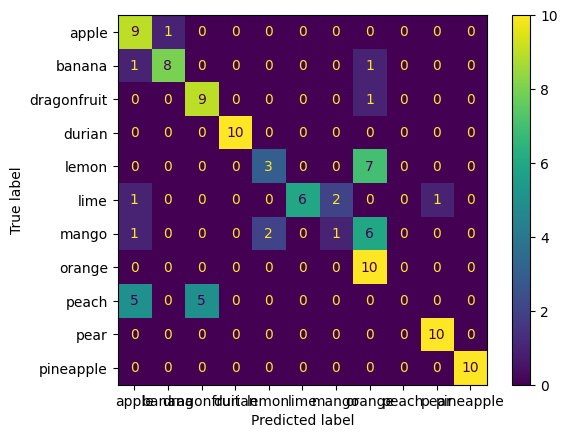

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [22]:
model.save('models/baseline_cnn_model_5', include_optimizer=True)

In [23]:
load_model = keras.models.load_model('models/baseline_cnn_model_4/', compile=False)

In [25]:
pred = load_model.predict(dataset_test)
pred = np.argmax(pred, axis=1)

gen_labels = (dataset_train.class_indices)
gen_labels = dict((v,k) for k,v in gen_labels.items())
pred = [gen_labels[k] for k in pred]
y_test = [gen_labels[k] for k in dataset_test.classes]

4/4 [==============================] - 5s 1s/step


KeyError: 11

In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

       apple      0.417     0.500     0.455        10
      banana      1.000     0.800     0.889        10
 dragonfruit      0.889     0.800     0.842        10
      durian      1.000     0.900     0.947        10
       lemon      1.000     0.200     0.333        10
        lime      1.000     0.600     0.750        10
       mango      0.667     0.600     0.632        10
      orange      0.476     1.000     0.645        10
       peach      1.000     0.200     0.333        10
        pear      0.769     1.000     0.870        10
   pineapple      1.000     0.900     0.947        10
  strawberry      0.500     1.000     0.667        10

    accuracy                          0.708       120
   macro avg      0.810     0.708     0.692       120
weighted avg      0.810     0.708     0.692       120



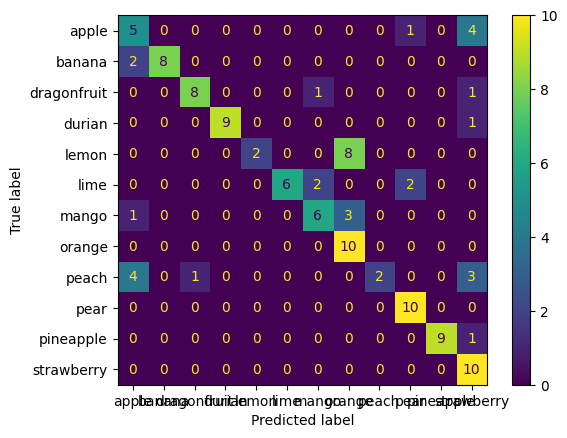

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [ ]:
gen_labels

{0: 'apple',
 1: 'banana',
 2: 'dragonfruit',
 3: 'durian',
 4: 'lemon',
 5: 'lime',
 6: 'mango',
 7: 'orange',
 8: 'peach',
 9: 'pear',
 10: 'pineapple',
 11: 'strawberry'}

In [ ]:
import pickle

f = open('dict_softmax/baseline_cnn_model_4.pkl', 'wb')
pickle.dump(gen_labels, f)
f.close()